# Annihilation Strain Function and Plot

In [1]:
import numpy as np
import mpmath as mp
# Requires omega in Hz, M in solar masses, alpha = dimensionless, r in kpc
# r is distance from us to binary

# H_ann gives the change in frequency from \omega_ann. Centered in the MHz, but with \delta f being extremely small.

Mp = 1.220890e19
G = 1 / Mp**2   


def h_pcr_ann(omega, mua, M,n,l, alpha, r, iota, phase ):

    def omega_ann(mua, alpha, n):
        return 2 * mua * (1 - alpha**2 / (2 * n**2))

    def h_ann(omega, M,n,l,alpha, r):

        # Define called on functions



        def gamma_a(l, alpha, M):
            if l == 1:
                p = 17
            else:
                p = 4 * l + 1
            rg = G * M
            return G * 1e-10 / rg**3 * (((alpha / l) * 0.5)**p + ((alpha / l) * 0.5)**(p + 1))

        def _mp_ei_vec(z):
            return np.vectorize(lambda zz: complex(mp.ei(zz)))(z)

        # Define Conversions and Constants
        Mp = 1.220890e19
        G = 1 / Mp**2
        M_sun = 2e30 * 5.61e26 # Solar mass - > Gev
        Mpc_to_Gev = 1.56e38        # 1 Mpc in GeV
        kpc_to_Gev = Mpc_to_Gev / 1000
        Hz_to_Gev = 4.1357e-24 # Hz - > Gev
        hbar_GeV = 6.582e-25 
        # Convert to natural units

        M_ann = M*M_sun # Solar mass -> GeV
        mua = alpha/(G*M_ann) # Mu in GeV
        r_kpc = r * kpc_to_Gev # Kpc - > GeV


        
        Gamma = gamma_a(l,alpha,M_ann)

        # Approximate maximum population of states
        N_max = 10**(76)*(M/10)**2
        omega = np.asarray(np.multiply(omega,Hz_to_Gev))
        z = 1j * omega / (Gamma * N_max)  # argument for Ei and exponential
        
        pref = 1/(2*np.pi)*np.sqrt(4.0 * G  / (Gamma*r_kpc**2 * omega_a))
        def _mp_E1_vec(z):
            return np.vectorize(lambda zz: complex(mp.e1(zz)))(z)

        # Use the stable exponential integral form
        Ei_part = _mp_E1_vec(z)


        Ei = np.exp(1j * omega / (Gamma * N_max)) * Ei_part
        freq = omega/ (2*np.pi*Hz_to_Gev)
        # frequency strain has units of h*Gev, need to convert to Hz and then divide by timescale of event (2e6) to match discrete fft
        return pref * np.exp(z) *Ei*hbar_GeV, freq
    omega_a = omega_ann(mua, alpha, n) 
    omega_a /= 4.1357e-24
    
    print(f'Omega_a = {omega_a:.4e} Hz')
    print(f'Max Omega = {max(omega)}')
    print(f'M = {M} solar masses, alpha = {alpha}, r = {r} kpc, n={n}, l={l}')
    hmin, freq = h_ann(omega - omega_a, M,n,l,alpha, r)
    hp, freq = h_ann(omega + omega_a, M,n,l,alpha, r)
    
    h_plus = (1 + np.cos(iota)**2)/4*(np.exp(1j*phase)*hmin +np.exp(-1j*phase)*hp )
    h_cross = (np.cos(iota))/(2*1j)*(np.exp(1j*phase)*hmin -np.exp(-1j*phase)*hp )

    return h_plus, h_cross, freq

Omega_a = 9.6061e+01 Hz
Max Omega = 1000000000.0
M = 310.0 solar masses, alpha = 0.46669320033490247, r = 1 kpc, n=4, l=3


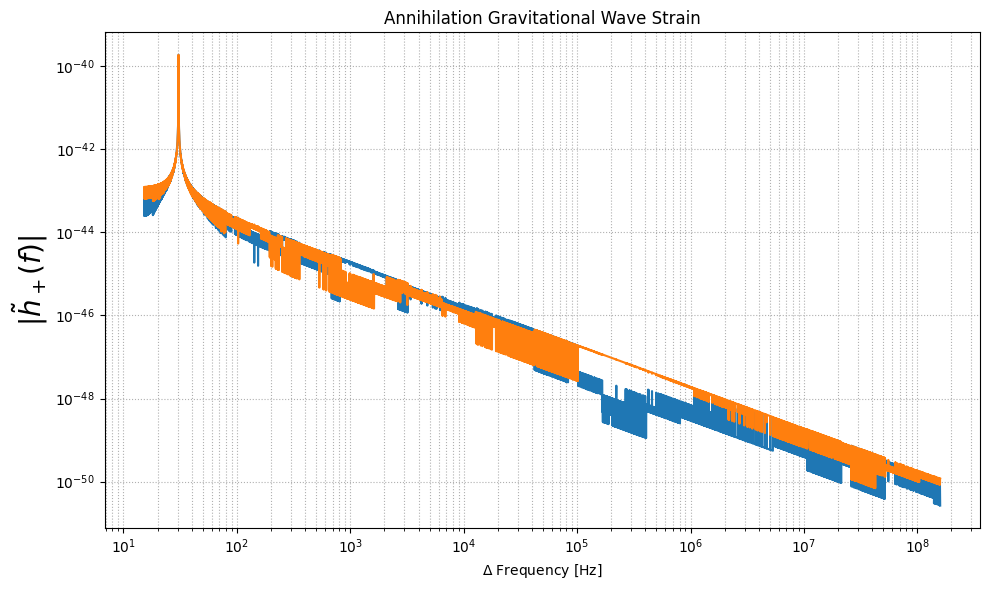

In [3]:
from matplotlib import pyplot as plt

# Plot label params
title_fs = 20
label_fs = 20
tick_fs  = 20
legend_fs = 15


# Relevant conversions
M_sun = 2e30 * 5.61e26 # Solar mass - > Gev

# Dependent Params
M_ann = 3.1e2 # in solar masses
mua_ann = 2e-22  # in GeV
alpha_ann = G*M_ann*mua_ann*M_sun
r_kpc = 1
n = 4
m = l = n-1
phase = 0 
iota = 0 
# call functions
omega = np.logspace(-2, 9, 10000) # in Hz

ann_strain_plus, ann_strain_cross,frequency = h_pcr_ann(omega, mua_ann, M_ann,n,l, alpha_ann, r_kpc, iota, phase )



plt.figure(figsize=(10, 6))
plt.title('Annihilation Gravitational Wave Strain')
plt.plot(frequency, np.abs(ann_strain_plus))
plt.plot(frequency, np.abs(ann_strain_cross))
plt.xlabel('$\\Delta$ Frequency [Hz]')
plt.ylabel(r"$|\tilde h_+(f)|$", fontsize=label_fs)
plt.xscale('log')
plt.yscale('log')    
# plt.xlim(1, 1e4)
# plt.ylim(1e-45, 1e-42)
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

# Binary Merger Template and Plot
check this code with Henry

In [120]:
import numpy as np
import math

def htilde_plus(
    f,                     # array-like (Hz )
    Msun, r, alpha,           # source mass (Solar mass), distance (kpc), fine-structure parameter,  
    q,                     # binary mass ratio (companion/host)
    m_i, m_f,              # initial/final magnetic quantum numbers (e.g., 1 -> -1)
    eta,                   # parameter entering z (or leave None to use z_scaling below,            
    use_z_scaling=False,    # if True, use Eq. (15.5) instead of z=η^2/(|Δm|γ)
    relativistic = False
):

    # Horizon Angular velocity funct, takes spin param a^* and r_plus spin horizon radius. Units are in inverse GeV
    def Omega_plus(a, r):
        return a / (2 * r)

    # Omega needs to be in units of GeV. Since mass is only thing dimensionfull, 
    # need to add a factor of G into denominator ( [1/(M*G)] = GeV )
    def Omega0_hyp(M, m_i, alpha, n, l):

        numerator = 64 * m_i * alpha**7
        denominator = G*M * n**3 * (2**l) * (2*l + 1) * (2*l + 2) * (m_i**2 + 4 * alpha**2)
        return numerator / denominator


    # Kerr spin horizon radius, takes Mass in Gev, and dimensionless spin
    def r_plus(M, a):
        return M * (1 + np.sqrt(1 - a**2)) * G
    
    # Superradiant rate in 
    def super_gamma(n, l, m, omega, mu, M, r, a):

        def glm(a, m, l, r, omega):
            g = 1
            if l == 1:
                g *= l**2 * (1 - a**2) + (a * m - 2 * r * omega)**2
            if l != 1:
                for k in range(1, l):
                    g *= k**2 * (1 - a**2) + (a * m - 2 * r * omega)**2
            return g

        C = (
            2**(4 * l - 1)
            * math.factorial(n + l)
            / (n**(2 * l + 4) * math.factorial(n - l - 1))
            * (math.factorial(l) / (math.factorial(2 * l) * math.factorial(2 * l + 1)))**2
        )
        g = glm(a, m, l, r, omega)
        omega_plus = Omega_plus(a, r)
        gamma_nlm = (
            2 * r / M * C * g * (m * omega_plus - omega) * (G * mu * M)**(4 * l + 5) / G 
        )
        return gamma_nlm

    # takes dimensionless quantum number m_i and alpha
    def a_tilde_crit(m_i, alpha):
        m2 = m_i**2
        return (4.0 * m_i * alpha) / (m2 + 4.0 * alpha**2)

    # all dimensionless
    def q_c(alpha, m_i, a_tilde):

        m = float(m_i)
        one_minus = (1.0 - a_tilde / m)
        # guard small rounding errors inside the sqrt:
        inner = 1.0 - (4.0 * alpha / m * one_minus) ** 2
        inner = np.clip(inner, 0.0, 1.0)

        denom = m**2 * (1.0 - np.sqrt(inner))**2
        # Avoid divide-by-zero:
        if denom == 0.0:
            return 0.0

        return 8.0 * alpha**2 * one_minus / denom


    # M is host BH mass


    # takes mass in Gev, dimensionless q_c, r in GeV is distance from Earth, Omega_0 is angular momentum at BH horizon in GeV
    def h0_from_params(qc, M, r, alpha, Omega0):

        return 24.0 * G*(qc * M / r) * (alpha ** -4) * (G*M * Omega0) ** 2

    def gamma_rate(q, M, Omega0):
        return (Omega0**2) * (96.0 / 5.0) * (q / (q + 1.0) ** (1.0 / 3.0)) * (M * Omega0) ** (5.0 / 3.0)


    def z_parameter(eta, Delta_m, gamma):
        return (eta ** 2) / (abs(Delta_m) * gamma)

    def z_scaling_211_to_21m1(alpha, q):
        """
        z_{211->21-1} ≈ 7 * (1.81/(1+4 α^2))^(1/3) * (q)^(1/3) * (2/(1+q))^(5/3) * (0.45/α)^(11/3)
        """
        return 7.0 * (1.81 / (1.0 + 4.0 * alpha**2)) ** (1.0 / 3.0) \
                * (q ** (1.0 / 3.0)) \
                * (2.0 / (1.0 + q)) ** (5.0 / 3.0) \
                * (0.45 / alpha) ** (11.0 / 3.0)

# Drop f*r term from phase, just want to see global phase, not one dependent on distance away
    def fc_from_Omega0(Omega0):
        return (2.0 / np.pi) * Omega0

    def psi_plus(f, r, f0, Delta_m, gamma):
        return   (f - f0) ** 2 / (4.0 * abs(Delta_m) * gamma) - np.pi / 4.0

    # New Function used in the adjusted amplitude from Henrys paper
    def g(z):
        z = np.asarray(z, dtype=np.complex128)
        num = np.exp(-np.pi*z + 2*z*np.arctan(2*z))
        den = np.sqrt(1 + 4*z**2)
        
        return num / den


    # Relavant constants/ conversions
    Mp = 1.220890e19
    G = 1 / Mp**2   
    M_sun = 2e30 * 5.61e26 # Solar mass - > Gev
    r *=  1.6e35 # Kpc -> GeV^-1
    # Convert to natural units
    M = Msun*M_sun # Solar mass - > GeV
    m_boson = alpha/(G*M) # Boson mass in GeV
    f *= 6.582e-25
    a = a_tilde_crit(m_i, alpha)
    Omega0 = Omega_plus(a,r_plus(M,a)) / (2.0/np.pi) 
    Omega_binary = Omega0_hyp(M, m_i, alpha, 2, 1)


    
    # gamma takes BH rotational freq
    if relativistic == False:
        Gamma_abs = super_gamma(2, 1, -1, Omega0, m_boson, M, r, a) 

    if relativistic == True:
        # Replace with relativistic superradiance rate
        Gamma_abs = 0 

    f = np.asarray(f, dtype=float)
    Delta_m = abs(m_f - m_i)

    # ã_crit and q_c
    acrit = a_tilde_crit(m_i, alpha)
    qc = q_c(alpha, m_i, acrit)

    # h0 amplitude (15.12)
    h0 = h0_from_params(qc, M, r, alpha, Omega_binary)

    gamma = gamma_rate(q, M, Omega_binary)

    # z (15.1) or scaling (15.5)
    if use_z_scaling:
        z = z_scaling_211_to_21m1(alpha, q)
    else:
        z = z_parameter(eta, Delta_m, gamma)

    # central frequency and phase (under 15.15)
    f_c = fc_from_Omega0(Omega_binary)
    
    f0 = f_c
    # print(f'{f0:.4}')
    phase = psi_plus(f, r, f0, Delta_m, gamma)

    # denominator and envelope
    denom = (np.sqrt(z) / abs(Gamma_abs)) - 1j * np.pi * (f - f_c)
    envelope = np.exp(-np.pi * z) * np.exp(-2.0 * z * np.arctan(np.pi * (f - f0) / abs(Gamma_abs)))

    # assemble, need factor of G to account for units of denominator gamma and freq ( 1/Hz = GeV, therefore need 1/Gev, -> sqrt(G)=1/Mp)
    # INcluded correction due to Henrys new eq
    pref = 4** g(z)*Delta_m**2*eta/Gamma_abs*np.sqrt(G)*h0 * (1.0 + np.cos(0.0)**2)* np.sqrt(np.pi) * (Delta_m ** 2)  # placeholder; will be overwritten below
    f /= 6.582e-25

    # Fix: include actual inclination:
    def with_inclination(iota):
        pref = h0*(1.0 + np.cos(iota) ** 2) * np.sqrt(np.pi) * (Delta_m ** 2)

        return np.sqrt(G)*pref * np.exp(1j * phase) * envelope / denom

    # For troubleshooting below
    print(f'h0 is: {h0}')
    print(f'Omega Binary: {Omega_binary/6.582e-25:.4e} Hz')
    print(f'Omega BH: {Omega0/6.582e-25:.4e} Hz')
    print(f'Prefix is: {pref:.4e}')
    print(f'envelope is: {max(envelope):.4e}')
    print(f'denom is: {min(denom):.4e}')
    print(f'Phase is: {min(phase):.4e}')
    print(f'Fc = {f_c/ 6.582e-25:.4e}  Hz')

    return with_inclination

    # Given h_+(f) and inclination iota [rad], return h_x(f)
def hcross_from_hplus_freq(hplus_f, iota):
    return 1j * (2*np.cos(iota)/(1+np.cos(iota)**2)) * hplus_f
    # Convert Freq axis back into hertz



h0 is: 3.382103682447387e-25
Omega Binary: 1.0819e+07 Hz
Omega BH: 9.5114e+10 Hz
Prefix is: -2.8699e-90-0.0000e+00j
envelope is: 1.0000e+00
denom is: 1.8605e-60-6.8470e-17j
Phase is: -7.8540e-01
Fc = 6.8877e+06  Hz


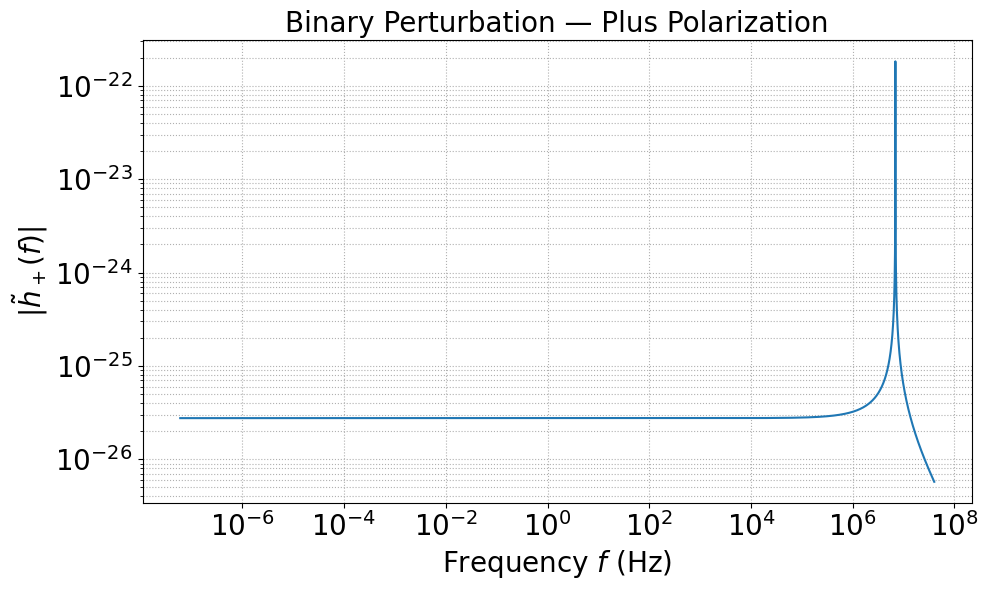

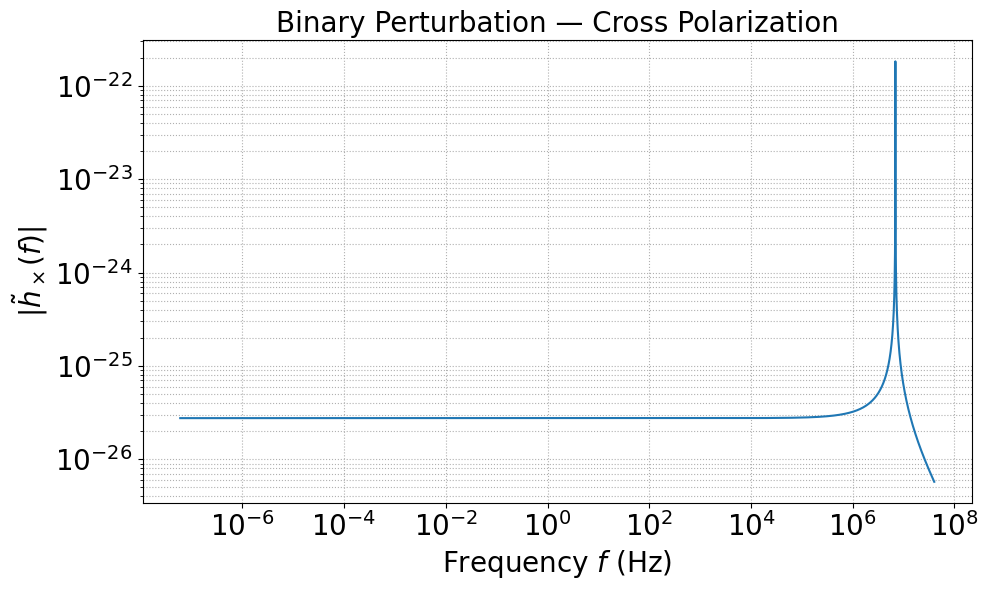

In [121]:

# Relevant Input parameters, units defined

Mp = 1.220890e19
G = 1 / Mp**2

M = 1e-6      # BH mass in solar masses
r = 1    # kpc distance away
alpha  = 0.3
m_boson = alpha/(G*M) # Boson mass in GeV
q      = 0.1 # Binary mass ratio
m_i    = 1
m_f    = -1 # Quantum Numbers
eta    = 5.0e-2      # parameter entering z (or leave None to use z_scaling below)
# Frequency in Gev   # width |Γ| in Hz (or your freq units)

# Found for this freq range, can also be estimated using Omega0 function 
frequency_axis = np.linspace(6e-8, 4e7, 10000)

hplus_of_iota = htilde_plus(frequency_axis, M, r, alpha, q, m_i, m_f, eta,use_z_scaling=False,relativistic = False  )
# f = np.linspace(6e-4, 4e15, 10000)
iota = np.pi  # rad
Hplus = hplus_of_iota(iota)
Hcross = hcross_from_hplus_freq(Hplus, iota)

# --- Plot h+ ---
plt.figure(figsize=(10,6))
plt.semilogy(frequency_axis, np.abs(Hplus))
plt.xlabel("Frequency $f$ (Hz)", fontsize=label_fs)
plt.ylabel(r"$|\tilde h_+(f)|$", fontsize=label_fs)
plt.title("Binary Perturbation — Plus Polarization", fontsize=title_fs)
plt.xscale('log')
plt.tick_params(axis='both', which='both', labelsize=tick_fs)
plt.grid(True, which='both', ls=":")
plt.tight_layout()
plt.show()

# --- Plot h× ---
plt.figure(figsize=(10,6))
plt.semilogy(frequency_axis, np.abs(Hcross))
plt.xlabel("Frequency $f$ (Hz)", fontsize=label_fs)
plt.ylabel(r"$|\tilde h_\times(f)|$", fontsize=label_fs)
plt.title("Binary Perturbation — Cross Polarization", fontsize=title_fs)
plt.xscale('log')
plt.tick_params(axis='both', which='both', labelsize=tick_fs)
plt.grid(True, which='both', ls=":")
plt.tight_layout()
plt.show()

# Isolated Level Transition and Plot

In [122]:
import numpy as np
import math
import matplotlib.pyplot as plt

def level_transition_strain(
    ne=6,
    ng=5,
    r_kpc=1.0,
    M_tr_solar=1e-6,
    mu_a=1e-13,
    a_tr=0.999999,
    omega_min_log=-29,
    omega_max_log=-25.5,
    n_omega=10000, iota = 0, phase = 0
):


    # ---------- CONSTANTS (local to this function) ----------
    Mp = 1.220890e19
    G = 1.0 / Mp**2               # GeV^-2
    M_sun = 1.989e30 * 5.61e26    # GeV
    Mpc_to_GeV = 1.56e38          # 1 Mpc in GeV
    kpc_to_GeV = Mpc_to_GeV / 1000.0
    hbar_GeV = 6.582119569e-25    # GeV·s

    # ---------- NESTED HELPER FUNCTIONS ----------
    def Omega_plus(a, r):
        return a / (2.0 * r)

    def r_plus(M, a):
        return M * (1.0 + np.sqrt(1.0 - a**2)) * G

    def glm(a, m, l, r, omega):
        g = 1.0
        if l == 1:
            g *= l**2 * (1.0 - a**2) + (a * m - 2.0 * r * omega)**2
        else:
            for k in range(1, l):
                g *= k**2 * (1.0 - a**2) + (a * m - 2.0 * r * omega)**2
        return g

    def super_gamma(n, l, m, omega, mu, M, r, a):
        C = (
            2**(4 * l - 1)
            * math.factorial(n + l)
            / (n**(2 * l + 4) * math.factorial(n - l - 1))
            * (math.factorial(l) / (math.factorial(2 * l) * math.factorial(2 * l + 1)))**2
        )
        g = glm(a, m, l, r, omega)
        omega_plus = Omega_plus(a, r)
        gamma_nlm = (
            2.0 * r / M * C * g * (m * omega_plus - omega) * (G * mu * M)**(4 * l + 5) / G
        )
        return gamma_nlm

    def gamma_t(ng, ne, mu, alpha, M):
        r_g = G * M
        r_c = ne**2 / alpha**2 * r_g
        omega = 0.5 * mu * alpha**2 * (1.0 / ng**2 - 1.0 / ne**2)
        return 2.0 * G * omega**5 / 5.0 * mu**2 * r_c**4

    def N_g_omega(omega, gamma_g, gamma_t_val, N_e, T):
        lam = gamma_g + gamma_t_val * N_e - 1j * omega
        return (1.0 / (2.0 * np.pi)) * (1.0 / lam) * (1.0 - np.exp(lam * T))

    def N_e_omega(omega, gamma_e, gamma_t_val, N_g, T):
        lam = gamma_e + gamma_t_val * N_g - 1j * omega
        return (1.0 / (2.0 * np.pi)) * (1.0 / lam) * (1.0 - np.exp(lam * T))

    def h_tr_omega(r, omega_tr, gamma_e, gamma_g, gamma_tr_val, T, omega, N_e, N_g):
        """
        h_{0,tr}(ω) in the Eq. (19.18) form:
          h_{0,tr}(ω) = 1/(2π) * sqrt(4 G Γ_t N_g N_e / (r^2 ω_tr))
                        / (Γ_e + Γ_g + Γ_t N_g - Γ_t N_e - i ω)
                        * ( -1 + exp[(Γ_e + Γ_g + Γ_t N_g - Γ_t N_e - i ω) T] )
        """
        omega = np.asarray(omega, dtype=np.complex128)
        gamma_e = np.asarray(gamma_e, dtype=np.complex128)
        gamma_g = np.asarray(gamma_g, dtype=np.complex128)
        N_e = np.asarray(N_e, dtype=np.complex128)
        N_g = np.asarray(N_g, dtype=np.complex128)

        lam = gamma_e + gamma_g + gamma_tr_val * N_g - gamma_tr_val * N_e - 1j * omega
        pref = np.sqrt(4.0 * G * gamma_tr_val * N_g * N_e / (r**2 * omega_tr))

        return (1.0 / (2.0 * np.pi)) * pref * (-1.0 + np.exp(lam * T)) / lam

    # ---------- SETUP PHYSICAL PARAMETERS ----------
    l = ng - 1
    m = l

    r = r_kpc * kpc_to_GeV              # kpc → GeV^-1
    M_tr = M_tr_solar * M_sun           # solar masses → GeV
    alpha_tr = G * M_tr * mu_a

    r_plus_tr = r_plus(M_tr, a_tr)
    _ = Omega_plus(a_tr, r_plus_tr)     # horizon frequency if needed

    # transition angular frequency, GeV
    omega_tr = 0.5 * mu_a * alpha_tr**2 * (1.0 / ng**2 - 1.0 / ne**2) 

    # frequency grid in GeV
    omega = np.logspace(omega_min_log, omega_max_log, n_omega)

    # superradiant rates Γ_e(ω), Γ_g(ω)
    gamma_e_vals = np.array(
        [super_gamma(ne, l, m, w, mu_a, M_tr, r_plus_tr, a_tr) for w in omega]
    )
    gamma_g_vals = np.array(
        [super_gamma(ng, l, m, w, mu_a, M_tr, r_plus_tr, a_tr) for w in omega]
    )

    # transition rate Γ_t
    gamma_tr_val = gamma_t(ng, ne, mu_a, alpha_tr, M_tr)

    # timescale T: use Γ_g at smallest ω
    T = 2.0 / gamma_g_vals[0]

    # build N_g(ω), N_e(ω)
    N_g_list = []
    N_e_list = []
    N_g0 = 0.0 + 0.0j
    N_e0 = 0.0 + 0.0j

    for idx, w in enumerate(omega):
        gamma_g = gamma_g_vals[idx]
        gamma_e = gamma_e_vals[idx]

        N_g0 = np.abs(N_g_omega(w, gamma_g,      gamma_tr_val, N_e0, T))
        N_e0 = np.abs(N_e_omega(w, gamma_e,      gamma_tr_val, N_g0, T))

        N_g_list.append(N_g0)
        N_e_list.append(N_e0)

    N_g_arr = np.array(N_g_list, dtype=np.complex128)
    N_e_arr = np.array(N_e_list, dtype=np.complex128)

    # final strain spectrum
    hp = h_tr_omega(
        r=r,
        omega_tr=omega_tr,
        gamma_e=gamma_e_vals,
        gamma_g=gamma_g_vals,
        gamma_tr_val=gamma_tr_val,
        T=T,
        omega=omega + omega_tr,
        N_e=N_e_arr,
        N_g=N_g_arr,
    )
    hmin = h_tr_omega(
        r=r,
        omega_tr=omega_tr,
        gamma_e=gamma_e_vals,
        gamma_g=gamma_g_vals,
        gamma_tr_val=gamma_tr_val,
        T=T,
        omega=omega - omega_tr,
        N_e=N_e_arr,
        N_g=N_g_arr,
    )

        # For troubleshooting below
    print(f'Omega Tr: {omega_tr/6.582e-25:.4e} Hz')
    print(f'Gamma_tr is: {gamma_tr_val:.4e}')


    # convert ω (GeV) → f (Hz): ω = 2π f  ⇒  f = ω / (2π ℏ)
    f_hz = omega / (2.0 * np.pi * hbar_GeV)
    h_plus = (1 + np.cos(iota)**2)/4*(np.exp(1j*phase)*hmin +np.exp(-1j*phase)*hp )
    h_cross = (np.cos(iota))/(2*1j)*(np.exp(1j*phase)*hmin -np.exp(-1j*phase)*hp )


    return omega, f_hz,h_plus, h_cross

Omega Tr: 5.2030e+08 Hz
Gamma_tr is: 6.7606e-84


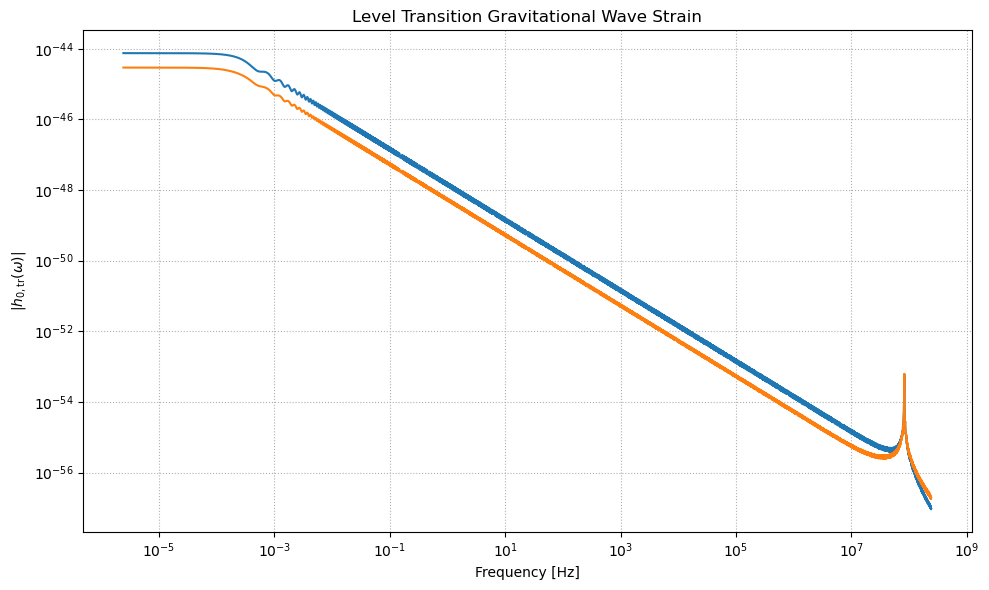

In [123]:

omega, f_hz, h_tr_plus,h_tr_cross = level_transition_strain(
    ne=6,
    ng=5,
    r_kpc=1.0,
    M_tr_solar=1e-6,
    mu_a=1e-13,
    a_tr=0.999999,
    omega_min_log=-29,
    omega_max_log=-15,
    n_omega=10000,
    iota = 0, phase = 0
)

h_abs_p = np.abs(h_tr_plus)
h_abs_cr =np.abs(h_tr_cross)

plt.figure(figsize=(10, 6))
plt.title("Level Transition Gravitational Wave Strain")
plt.plot(f_hz, h_abs_p)
plt.plot(f_hz, h_abs_cr)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$|h_{0,\mathrm{tr}}(\omega)|$")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls=":")
plt.tight_layout()